In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks

In [2]:
os.listdir('models')

['scannet_no_planar', 'scannet_keypts', 'scannet_less_keypts', 'scannet_1']

In [3]:
def load_model(model_name, weights_dir):
    encoder_path = os.path.join("models", model_name, "models", weights_dir, "encoder.pth")
    depth_decoder_path = os.path.join("models", model_name, "models", weights_dir, "depth.pth")

    encoder = networks.ResnetEncoder(18, False)
    depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

    loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)

    loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
    depth_decoder.load_state_dict(loaded_dict)
    
    img_size = (loaded_dict_enc['width'], loaded_dict_enc['height'])

    encoder.eval()
    depth_decoder.eval()
    
    return encoder, depth_decoder, img_size

## Loading the test image and preprocessing

In [5]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = 288
feed_width = 384
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [6]:
encoder, decoder, img_size = load_model('scannet_keypts', 'weights_21')

with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = decoder(features)

disp = outputs[("disp", 0)]

## Plotting

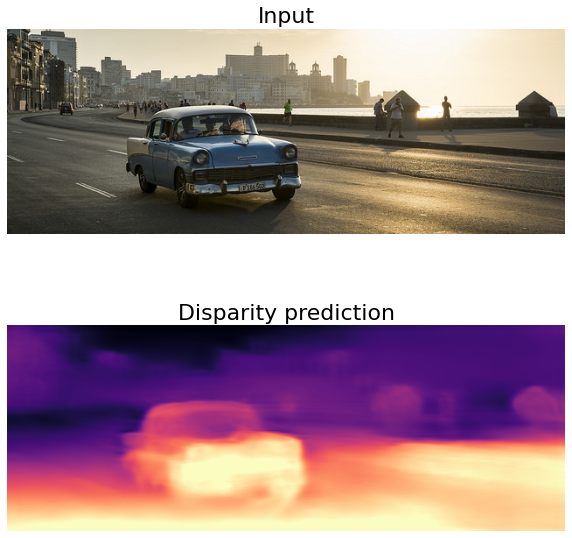

In [7]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

## Evaluate models

In [12]:
import torch
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader

from layers import disp_to_depth
from utils import readlines
import datasets

In [9]:
os.listdir('models')

['scannet_no_planar', 'scannet_keypts', 'scannet_less_keypts', 'scannet_1']

In [13]:
def save_pred_disps(model_name, weights_dir):
    data_path = "/scratch/shantanu/scannet_data"
    filenames = readlines(os.path.join(os.getcwd(), "splits", "scannet", "eval_files.txt"))
    batch_size = 32

    encoder, decoder, img_size = load_model(model_name, weights_dir)
    eval_dataset = datasets.ScanNetDataset(data_path, filenames, height=img_size[1], width=img_size[0], 
                                           frame_idxs=[0], num_scales=4, is_train=False)
    dataloader = DataLoader(eval_dataset, batch_size, shuffle=False, num_workers=4, 
                            pin_memory=True, drop_last=False)

    encoder.cuda()
    decoder.cuda()

    pred_disps = []
    filepaths = []

    with torch.no_grad():
        for data in tqdm(dataloader):
            input_color = data[("color", 0, 0)].cuda()
            filepaths.extend(data["filepath"])

            output = decoder(encoder(input_color))

            pred_disp, _ = disp_to_depth(output[("disp", 0)], 0.1, 10.0)
            pred_disp = pred_disp.cpu()[:, 0].numpy()

            pred_disps.append(pred_disp)

    pred_disps = np.concatenate(pred_disps)

    save_dir = os.path.join("models", model_name, "models", weights_dir, "predictions")
    print("-> Saving out predictions to {}".format(save_dir))
    os.makedirs(save_dir, exist_ok=True)

    for idx in range(len(pred_disps)):
        folder, fileidx = filepaths[idx].split()
        tgt_dir = os.path.join(save_dir, folder)
        filename = str(fileidx)

        os.makedirs(tgt_dir, exist_ok=True)
        np.save(os.path.join(tgt_dir, "{}.npy".format(filename)), pred_disps[idx])

In [14]:
model_name = "scannet_keypts"
weights_dir = "weights_21"

save_pred_disps(model_name, weights_dir)

/home/shantanusingh/.local/lib/python3.7/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



-> Saving out predictions to models/scannet_keypts/models/weights_21/predictions


In [15]:
model_name = "scannet_1"
weights_dir = "weights_17"

save_pred_disps(model_name, weights_dir)

/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



-> Saving out predictions to models/scannet_1/models/weights_17/predictions


In [16]:
model_name = "scannet_no_planar"
weights_dir = "weights_7"

save_pred_disps(model_name, weights_dir)

/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



-> Saving out predictions to models/scannet_no_planar/models/weights_7/predictions


In [17]:
model_name = "scannet_less_keypts"
weights_dir = "weights_6"

save_pred_disps(model_name, weights_dir)

/home/shantanusingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



-> Saving out predictions to models/scannet_less_keypts/models/weights_6/predictions
